In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('KA.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Recovered'

In [5]:
df.Date.describe()

count           115
unique          115
top       30-May-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Deceased
0,14-Mar-20,6,0,1
1,15-Mar-20,0,0,0
2,16-Mar-20,1,0,0
3,17-Mar-20,2,0,0
4,18-Mar-20,5,0,0
...,...,...,...,...
110,02-Jul-20,1502,271,19
111,03-Jul-20,1694,471,21
112,04-Jul-20,1839,439,42
113,05-Jul-20,1925,603,37


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0


In [9]:
df

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0
...,...,...,...,...
110,2020-07-02,1502,271,19
111,2020-07-03,1694,471,21
112,2020-07-04,1839,439,42
113,2020-07-05,1925,603,37


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


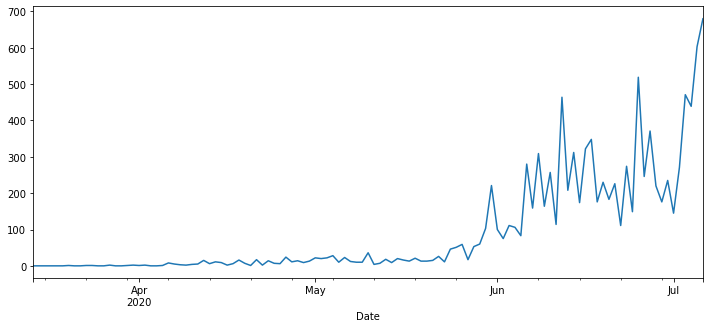

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        1.056565
p-value                   0.994828
# lags used              13.000000
# observations          101.000000
critical value (1%)      -3.496818
critical value (5%)      -2.890611
critical value (10%)     -2.582277
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


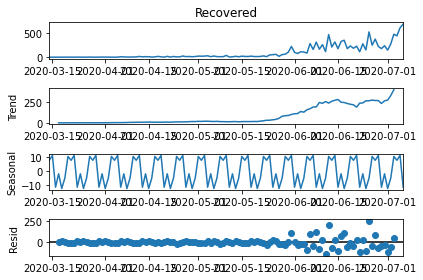

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.830363
p-value                  0.002611
# lags used             13.000000
# observations          99.000000
critical value (1%)     -3.498198
critical value (5%)     -2.891208
critical value (10%)    -2.582596
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=9)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1344.026, BIC=1349.499, Time=0.017 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1282.225, BIC=1290.434, Time=0.033 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1302.942, BIC=1311.151, Time=0.061 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1342.569, BIC=1345.305, Time=0.008 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1282.929, BIC=1293.874, Time=0.057 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1283.047, BIC=1293.992, Time=0.098 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1284.914, BIC=1298.595, Time=0.129 seconds
Total fit time: 0.413 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -638.113
Date:                Tue, 14 Jul 2020   AIC                           1282.225
Time:                        05:10:31   BIC                           1290.434
Sample:                             0   HQIC                          1285.557
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.5063      8.177      1.163      0.245      -6.521      25.533
ar.L1         -0.6531      0.049    -13.444      0.000      -0.748      -0.558
sigma2      4239.3323    360.396     11.763      0.000    3532.969    4945.696
===================================================================================
Ljung-Box (Q):                       38.60   Jarque-Bera (JB):               286.57
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):             124.64   Skew:                             1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:90]
test = df.iloc[90:]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(1, 1, 0))
model = SARIMAX(train[para],order=(1, 1, 0),seasonal_order=(1,1,0,9))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Recovered   No. Observations:                   90
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 9)   Log Likelihood                -399.232
Date:                           Tue, 14 Jul 2020   AIC                            804.463
Time:                                   05:10:31   BIC                            811.609
Sample:                               03-14-2020   HQIC                           807.328
                                    - 06-11-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7425      0.062    -12.029      0.000      -0.863      -0.621
ar.S.L9       -0.5181      0.086     -5.998      0.000      -0.687      -0.349
sigma2      1208.5800     76.268     15.847      0.000    1059.098    1358.062
===================================================================================
Ljung-Box (Q):                       43.51   Jarque-Bera (JB):               534.86
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):             174.17   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,1,0,9) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

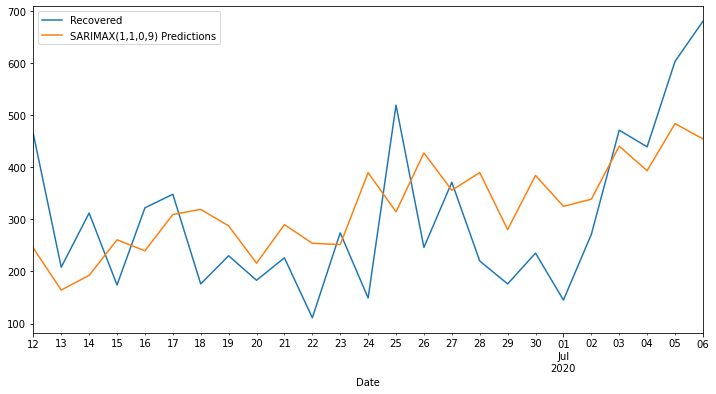

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

111.46886447617946

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

1.475822381519654 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Deceased,d1,forecast
Date,,,,,
2020-03-14,6,0,1,NaN,NaN
2020-03-15,0,0,0,NaN,NaN
2020-03-16,1,0,0,0.0,NaN
2020-03-17,2,0,0,0.0,NaN
2020-03-18,5,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,1502,271,19,216.0,338.513618
2020-07-03,1694,471,21,74.0,440.213945
2020-07-04,1839,439,42,-232.0,393.260732


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Recovered': Date
 2020-06-12    464
 2020-06-13    208
 2020-06-14    312
 2020-06-15    174
 2020-06-16    322
 2020-06-17    348
 2020-06-18    176
 2020-06-19    230
 2020-06-20    183
 2020-06-21    226
 2020-06-22    111
 2020-06-23    274
 2020-06-24    149
 2020-06-25    519
 2020-06-26    246
 2020-06-27    371
 2020-06-28    220
 2020-06-29    176
 2020-06-30    235
 2020-07-01    145
 2020-07-02    271
 2020-07-03    471
 2020-07-04    439
 2020-07-05    603
 2020-07-06    680
 Freq: D, Name: Recovered, dtype: int64,
 'Predicted_Recovered': 2020-06-12    244.630284
 2020-06-13    164.180923
 2020-06-14    192.356099
 2020-06-15    260.634402
 2020-06-16    239.590658
 2020-06-17    309.177627
 2020-06-18    318.985193
 2020-06-19    287.340768
 2020-06-20    215.700358
 2020-06-21    289.711762
 2020-06-22    253.988806
 2020-06-23    251.465608
 2020-06-24    389.543066
 2020-06-25    314.403998
 2020-06-26    427.366668
 2020-06-27    355.694400
 2020-06-28    389.574347


In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Recovered,Predicted_Recovered
Date,,
2020-06-12,464,244.630284
2020-06-13,208,164.180923
2020-06-14,312,192.356099
2020-06-15,174,260.634402
2020-06-16,322,239.590658
2020-06-17,348,309.177627
2020-06-18,176,318.985193
2020-06-19,230,287.340768
2020-06-20,183,215.700358


In [33]:
# predicted_df.to_csv('Predicted_KA.csv')
predicted_csv = pd.read_csv('Predicted_KA.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_KA.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered
Date                                                                      
2020-06-12        271           223.871454        464           244.630284
2020-06-13        308           281.319221        208           164.180923
2020-06-14        176           355.996197        312           192.356099
2020-06-15        213           228.717272        174           260.634402
2020-06-16        317           407.783614        322           239.590658
2020-06-17        204           215.748763        348           309.177627
2020-06-18        210           315.136916        176           318.985193
2020-06-19        337           276.869091        230           287.340768
2020-06-20        416           314.052275        183           215.700358
2020-06-21        453           468.076719        226           289.711762
2020-06-22        249           498.035694        111           253.988806
2020-06-23        322    

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Deceased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Deceased,forecast
2020-03-14,6,0,1,NaN
2020-03-15,0,0,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,2,0,0,NaN
2020-03-18,5,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Recovered,forecast
2020-03-14,0,NaN
2020-03-15,0,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

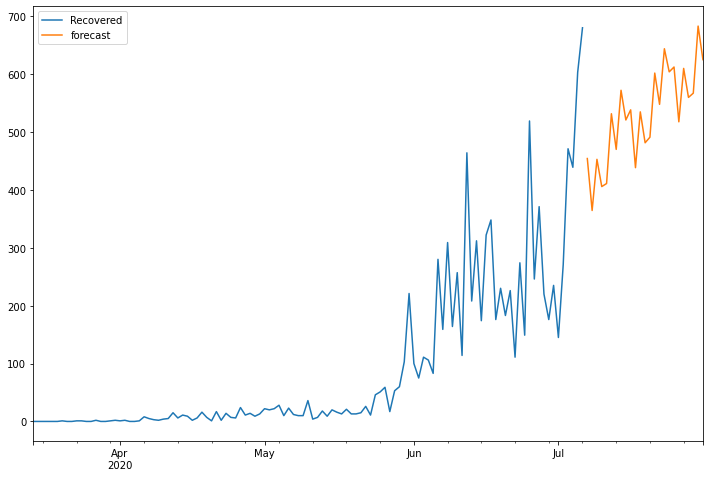

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Recovered': 2020-07-07    454.129224
 2020-07-08    364.382675
 2020-07-09    452.745281
 2020-07-10    405.695725
 2020-07-11    410.955600
 2020-07-12    531.518157
 2020-07-13    469.950518
 2020-07-14    572.034977
 2020-07-15    520.741950
 2020-07-16    538.235563
 2020-07-17    438.347540
 2020-07-18    534.745676
 2020-07-19    481.356035
 2020-07-20    490.974176
 2020-07-21    601.762880
 2020-07-22    547.767974
 2020-07-23    643.783224
 2020-07-24    603.849841
 2020-07-25    612.209927
 2020-07-26    517.576605
 2020-07-27    609.811224
 2020-07-28    559.706617
 2020-07-29    567.066571
 2020-07-30    682.919349
 2020-07-31    625.000826
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Recovered
2020-07-07,454.129224
2020-07-08,364.382675
2020-07-09,452.745281
2020-07-10,405.695725
2020-07-11,410.955600
2020-07-12,531.518157
2020-07-13,469.950518
2020-07-14,572.034977
2020-07-15,520.741950
2020-07-16,538.235563


In [44]:
# future_predicted_df.index.names = ['Date']
# future_predicted_df.index.freq = 'D'
# future_predicted_df.to_csv('Future_Predicted_KA.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_KA.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_KA.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered
Date                                                              
2020-07-07                  671.080971                  454.129224
2020-07-08                  651.048361                  364.382675
2020-07-09                  377.514099                  452.745281
2020-07-10                  612.181703                  405.695725
2020-07-11                  278.708063                  410.955600
2020-07-12                  413.414843                  531.518157
2020-07-13                  381.917772                  469.950518
2020-07-14                  419.054784                  572.034977
2020-07-15                  726.654030                  520.741950
2020-07-16                  691.837438                  538.235563
2020-07-17                  389.638162                  438.347540
2020-07-18                  638.421843                  534.745676
2020-07-19                  275.932137                  481.35